# 1. Load train and test data using pandas or numpy. (2 points)

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("hw1_train.csv")
train_data.head()

,Target,Time-0,Time-1,Time-2,Time-3,Time-4,Time-5,Time-6,Time-7,Time-8,...,Time-490,Time-491,Time-492,Time-493,Time-494,Time-495,Time-496,Time-497,Time-498,Time-499
0,-1,-0.14040,0.17164,0.30204,0.23280,0.033853,-0.22418,-0.46999,-0.645400,-0.61770,...,-0.31997,0.39090,0.97483,1.258700,1.14330,0.64709,-0.049582,-0.690400,-0.97660,-0.79426
1,-1,0.33404,0.32225,0.45384,0.67185,0.887900,1.02050,1.05980,1.030300,0.95075,...,0.43519,-0.34650,-0.92491,-1.208700,-1.24800,-1.14000,-1.041800,-1.041800,-1.15960,-1.37570
2,-1,0.71669,0.74437,0.72591,0.66133,0.555220,0.41359,0.24658,0.065273,-0.12111,...,3.17100,2.27600,1.21950,0.081881,-1.05030,-2.09290,-2.983300,-3.675300,-4.13660,-4.33960
3,1,1.24030,1.33120,1.38660,1.38320,1.306000,1.14280,0.87861,0.532290,0.14002,...,-0.82026,-1.12460,-1.30200,-1.340600,-1.27140,-1.14640,-1.011300,-0.931220,-0.93450,-1.00130
4,-1,-1.15950,-1.20420,-1.16760,-1.03350,-0.818170,-0.55812,-0.29929,-0.093691,0.02277,...,0.66085,0.44144,0.20618,-0.006941,-0.14692,-0.18308,-0.112380,0.008987,0.13141,0.18627


In [3]:
test_data = pd.read_csv("hw1_test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, Target to Time-499
dtypes: float64(500), int64(1)
memory usage: 13.8 MB


# 2. Plot & analyze several training examples of each class using plt.plot          (3 points)

Plot input signals and its FFTs in the train dataset as overlays

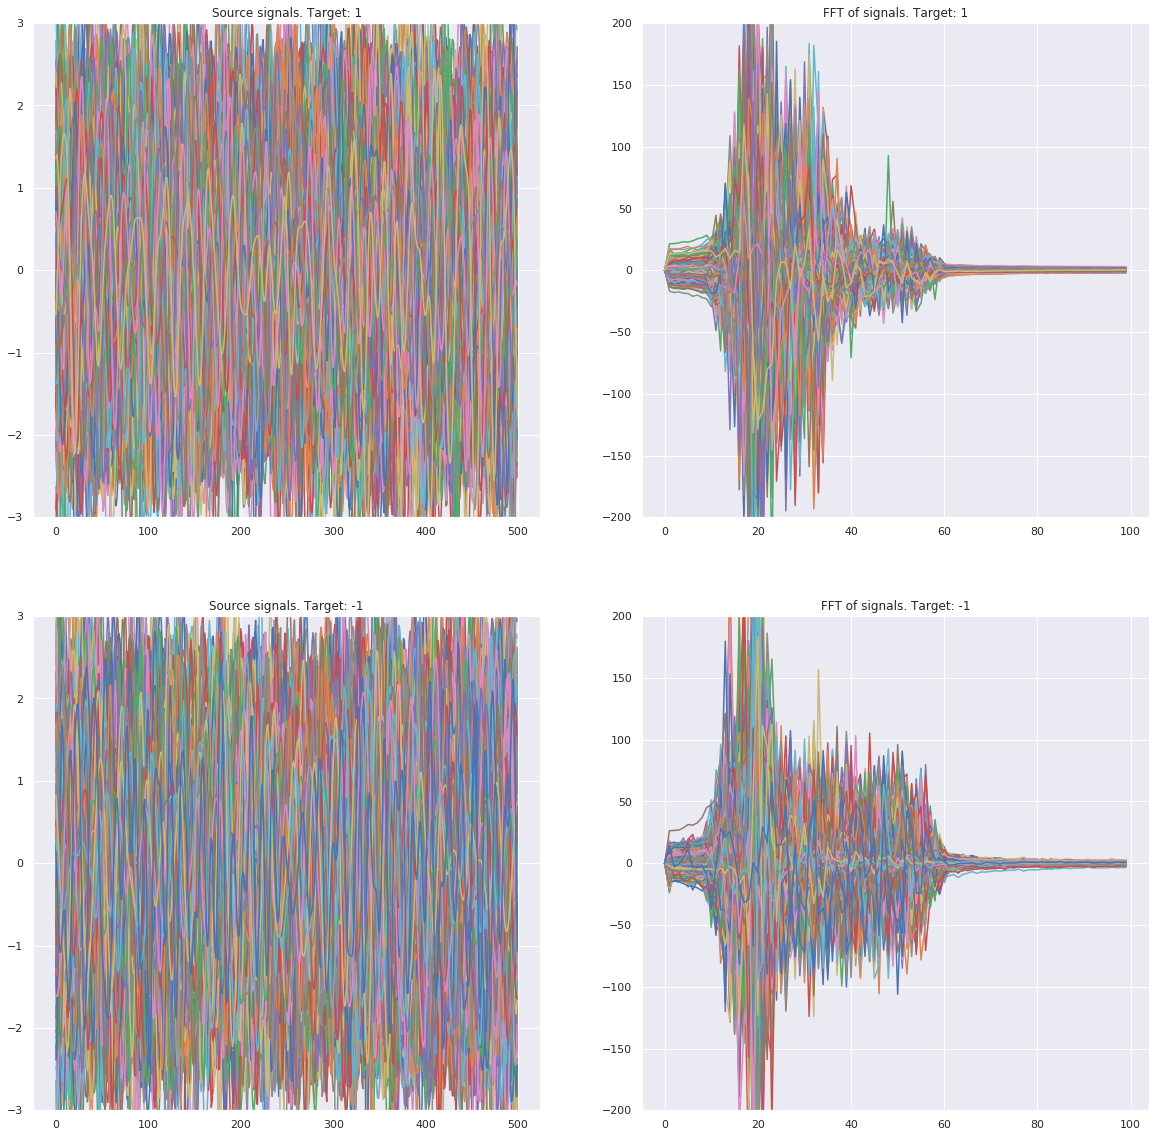

In [4]:
FIG_NUM = 1320
fig, axes = plt.subplots(2, 2, figsize=(20,20))    

t = np.arange(500)
freq = np.fft.fftfreq(t.shape[-1])
lbl1 = "Source signals. Target: 1"
lbl2 = "Source signals. Target: -1"
lbl3 = "FFT of signals. Target: 1"
lbl4 = "FFT of signals. Target: -1" 

for i in range(FIG_NUM):
    if (train_data.iloc[i][0] == 1.0): 
        axes[0, 0].set_title(lbl1)
        axes[0, 0].set_ylim([-3,3])
        axes[0, 0].plot(t, train_data.iloc[i][1:])
        axes[0, 1].set_title(lbl3)
        sp = np.fft.fft(train_data.iloc[i][1:])
        axes[0, 1].set_ylim([-200,200])
        axes[0, 1].plot(t[0:100], sp.real[0:100])

    if (train_data.iloc[i][0] == -1.0): 
        axes[1, 0].set_title(lbl2)
        axes[1, 0].set_ylim([-3,3])
        axes[1, 0].plot(t, train_data.iloc[i][1:])
        axes[1, 1].set_title(lbl4)
        sp = np.fft.fft(train_data.iloc[i][1:])
        axes[1, 1].set_ylim([-200,200])
        axes[1, 1].plot(t[0:100], sp.real[0:100])

# 3. Propose several features potentially useful for classification. (5 points)

In [5]:
train_new_feat = pd.DataFrame(train_data['Target'], columns=['Target'])
test_new_feat = pd.DataFrame(test_data['Target'], columns=['Target'])

**Feature 1**. Based on section 2, let's consider the power of input signal in time domain, but to avoid noise the signal should be smoothed, i.e. apply rolling window and compute value for each frame. Then add computed values to the final dataframe.

In [6]:
import numpy as np

train_data_sm = train_data.drop(['Target'], axis=1).rolling(window=60, axis=1).mean().dropna(axis=1)
train_new_feat['sig_energy'] = train_data_sm.apply((lambda x: np.square(x).sum()), axis=1)

test_data_sm = test_data.drop(['Target'], axis=1).rolling(window=60, axis=1).mean().dropna(axis=1)
test_new_feat['sig_energy'] = test_data_sm.apply((lambda x: np.square(x).sum()), axis=1)

**Feature 2**. Moreover, it is clearly shown, that amplitude of overlayed signals in section 2 in freq. domain is much higher for the '-1' class than for the '1' class. But it works only for high frequency region (approximately from 45th to 70th sample). So in such a way let's compute the power of signals in high freq. region and present is as second feature. 

In [7]:
fft_hf_power = [abs(x[45:70]).sum() for x in np.fft.fft(train_data.drop(['Target'], axis=1))]
train_new_feat['fft_hf_weight'] = pd.DataFrame(fft_hf_power, columns=['fft_hf_weight'])

fft_hf_power = [abs(x[45:70]).sum() for x in np.fft.fft(test_data.drop(['Target'], axis=1))]
test_new_feat['fft_hf_weight'] = pd.DataFrame(fft_hf_power, columns=['fft_hf_weight'])

**Killer feature**. Sometimes, some miracles happen, thus let's consider the feature like the number of unique values in time series (values which appeared just at once)

In [8]:
train_new_feat['val_counts'] = train_data.drop(['Target'], axis=1).apply((lambda x: len(x.value_counts())), axis=1)

test_new_feat['val_counts'] = test_data.drop(['Target'], axis=1).apply((lambda x: len(x.value_counts())), axis=1)

#### Prepare X_train, Y_train, X_test and Y_test 

In [9]:
Y_train = train_new_feat['Target']
X_train = train_new_feat.drop(['Target'], axis=1)

Y_test = test_new_feat['Target']
X_test = test_new_feat.drop(['Target'], axis=1)

# 4. Calculate the proposed features using numpy and visualize the new representation of training examples. (7 points)

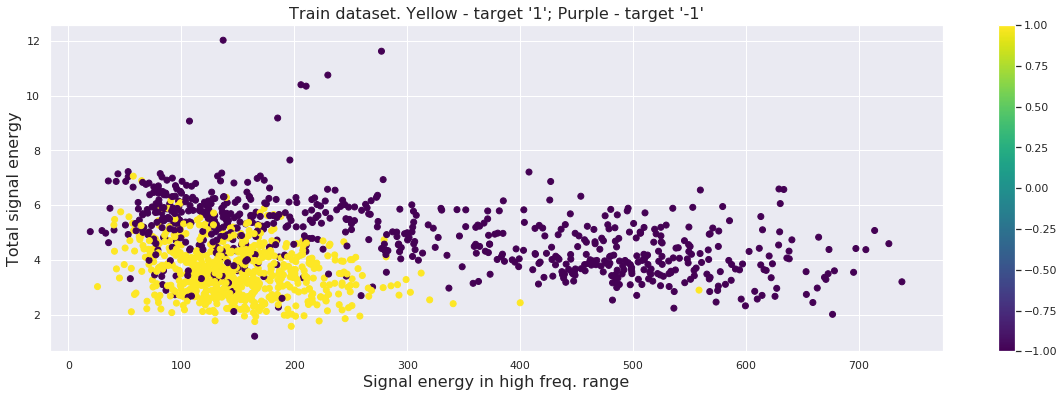

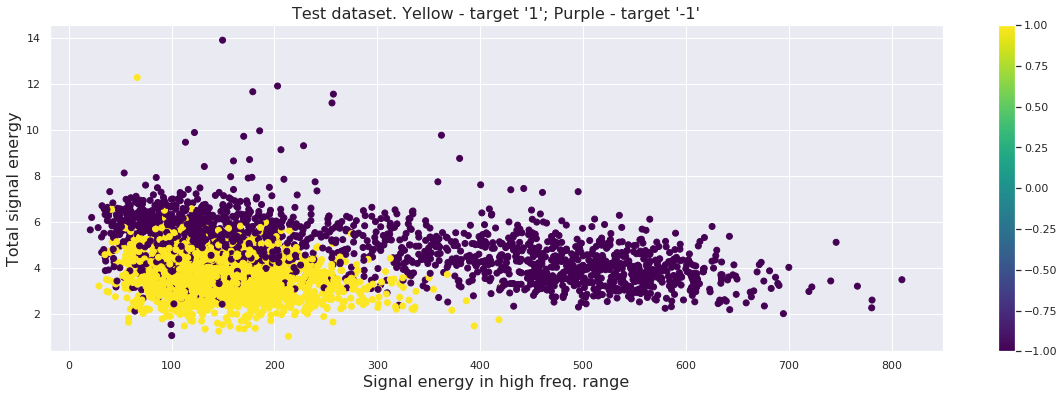

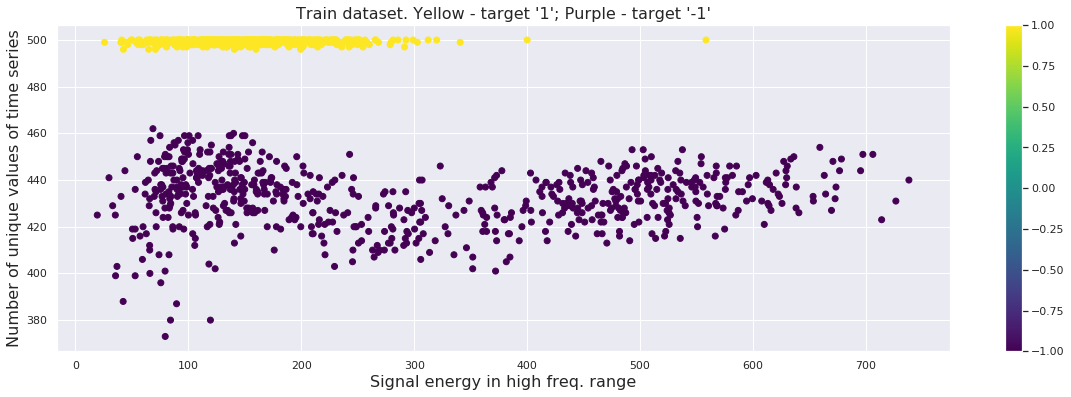

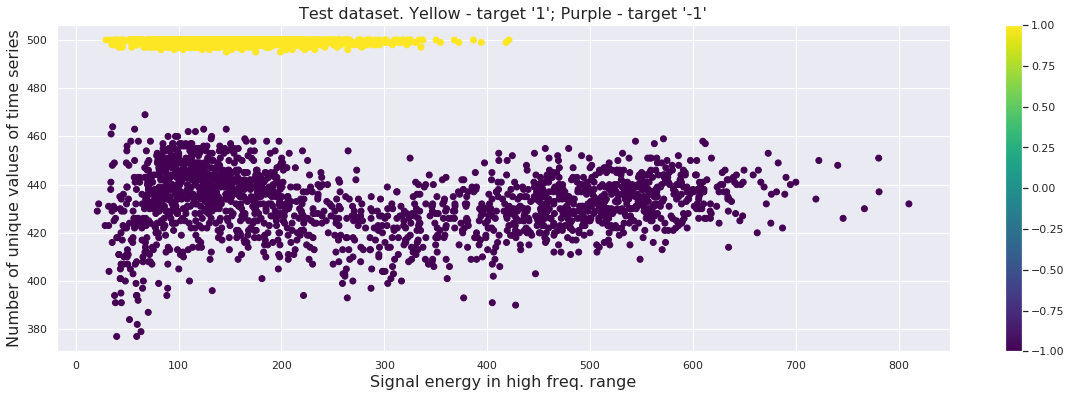

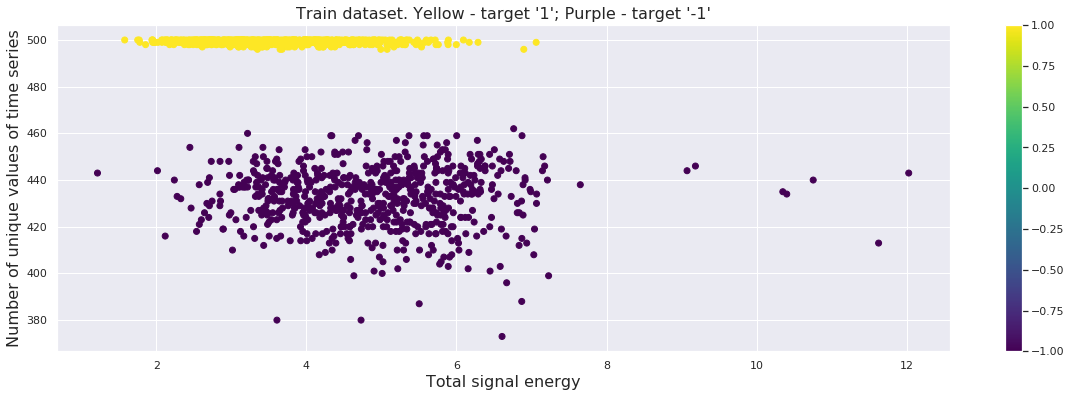

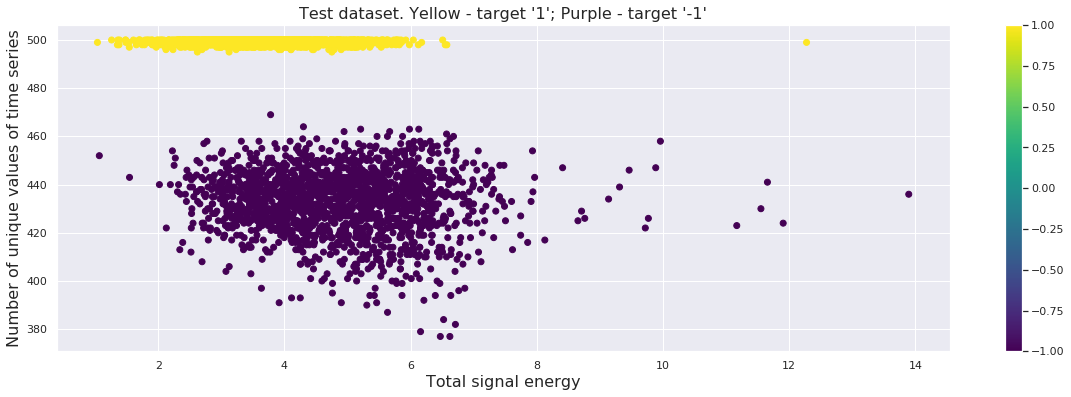

In [10]:
#Train dataset(fft_hf_weight and sig_energy)
plt.figure(figsize=(20, 6))
plt.title("Train dataset. Yellow - target '1'; Purple - target '-1'", size=16)
plt.xlabel(xlabel = "Signal energy in high freq. range", size=16)
plt.ylabel(ylabel = "Total signal energy", size=16)
plt.scatter(X_train['fft_hf_weight'], X_train['sig_energy'], c=Y_train, cmap='viridis')
plt.colorbar();

#Test dataset(fft_hf_weight and sig_energy)
plt.figure(figsize=(20, 6))
plt.title("Test dataset. Yellow - target '1'; Purple - target '-1'", size=16)
plt.xlabel(xlabel = "Signal energy in high freq. range", size=16)
plt.ylabel(ylabel = "Total signal energy", size=16)
plt.scatter(X_test['fft_hf_weight'], X_test['sig_energy'], c=Y_test, cmap='viridis')
plt.colorbar();

#Train dataset(fft_hf_weight and val_counts)
plt.figure(figsize=(20, 6))
plt.title("Train dataset. Yellow - target '1'; Purple - target '-1'", size=16)
plt.xlabel(xlabel = "Signal energy in high freq. range", size=16)
plt.ylabel(ylabel = "Number of unique values of time series", size=16)
plt.scatter(X_train['fft_hf_weight'], X_train['val_counts'], c=Y_train, cmap='viridis')
plt.colorbar();

#Test dataset(fft_hf_weight and val_counts)
plt.figure(figsize=(20, 6))
plt.title("Test dataset. Yellow - target '1'; Purple - target '-1'", size=16)
plt.xlabel(xlabel = "Signal energy in high freq. range", size=16)
plt.ylabel(ylabel = "Number of unique values of time series", size=16)
plt.scatter(X_test['fft_hf_weight'], X_test['val_counts'], c=Y_test, cmap='viridis')
plt.colorbar();

#Train dataset(sig_energy and val_counts)
plt.figure(figsize=(20, 6))
plt.title("Train dataset. Yellow - target '1'; Purple - target '-1'", size=16)
plt.xlabel(xlabel = "Total signal energy", size=16)
plt.ylabel(ylabel = "Number of unique values of time series", size=16)
plt.scatter(X_train['sig_energy'], X_train['val_counts'], c=Y_train, cmap='viridis')
plt.colorbar();

#Test dataset(sig_energy and val_counts)
plt.figure(figsize=(20, 6))
plt.title("Test dataset. Yellow - target '1'; Purple - target '-1'", size=16)
plt.xlabel(xlabel = "Total signal energy", size=16)
plt.ylabel(ylabel = "Number of unique values of time series", size=16)
plt.scatter(X_test['sig_energy'], X_test['val_counts'], c=Y_test, cmap='viridis')
plt.colorbar();

# 5. Repeat steps 3-4 if needed.

 Three features have been already introduced in section 4

# 6. Propose a simple decision rule using the proposed features. Estimate accuracy of classification using the test set. (3 points)

In [11]:
from sklearn.metrics import accuracy_score

# Simple decision rule taking into account energy characteristics
def predict_target(row):
    if (row['fft_hf_weight'] <= 258.623 and row['sig_energy'] <= 4.71):
        return 1
    return -1

# The simplest decision rule taking into account the killer feature
def predict2_target(row):
    if (row['val_counts'] > 480):
        return 1
    return -1
    
X_train['pred_target'] = X_train.apply(predict_target, axis=1)
X_test['pred_target'] = X_test.apply(predict_target, axis=1)
print("Test data acc(energy features):", accuracy_score(X_train['pred_target'], Y_train))
print("Train data acc(energy features):", accuracy_score(X_test['pred_target'], Y_test))
print()
X_train['pred_target'] = X_train.apply(predict2_target, axis=1)
X_test['pred_target'] = X_test.apply(predict2_target, axis=1)
print("Test data acc(killer feature):", accuracy_score(X_train['pred_target'], Y_train))
print("Train data acc(killer feature):", accuracy_score(X_test['pred_target'], Y_test))

Test data acc(energy features): 0.8742424242424243
Train data acc(energy features): 0.8536517633990558

Test data acc(killer feature): 1.0
Train data acc(killer feature): 1.0
